#Recency

#When did the customer interact with the company recently and how long has it been since the last time?

In [ ]:
import pandas as pd

df = pd.read_csv("orders.csv")
df = df.loc[df['city_name_fa'] == 'تهران']
print("Min_Date:", df['DateTime_CartFinalize'].min(), ", Max_Date:", df['DateTime_CartFinalize'].max())
df['DateTime_CartFinalize'] = df['DateTime_CartFinalize'].astype(str)
df['DateTime_CartFinalize'] = df['DateTime_CartFinalize'].str.replace('\D', '').astype(int)

recency = (df['DateTime_CartFinalize'].max() - df.groupby("ID_Customer").agg({"DateTime_CartFinalize":"max"}).rename(columns = {"DateTime_CartFinalize":"Recency"}))
recency
recency.to_csv('recency.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Min_Date: 00:00.0 , Max_Date: 59:59.0


#Frequency

###The number of times a customer orders or purchases in a specific period of time. The higher the value of this variable, the greater the customer loyalty.

In [ ]:

frequency = df.groupby("ID_Customer").agg({"DateTime_CartFinalize":"nunique"}).rename(columns={"DateTime_CartFinalize": "Frequency"})
print(frequency)
frequency.to_csv('frequency.csv')

             Frequency
ID_Customer           
466132               6
466141               2
466163               1
466211               1
466212               1
...                ...
999260               1
999560               1
999626               1
999669               1
999854               1

[90075 rows x 1 columns]


#Monetary

######Financial transaction volume, how much financial transaction did the customer have with the company during a specific period of time? The higher the value of this variable, the more importance the company should attach to this customer.




In [ ]:
df["TotalPrice"] = df["Amount_Gross_Order"] * df["Quantity_item"]

monetary = df.groupby("ID_Customer").agg({"TotalPrice":"sum"}).rename(columns={"TotalPrice":"Monetary"})
print(monetary)
monetary.to_csv('monetary.csv')

               Monetary
ID_Customer            
466132       31259158.0
466141        1174312.0
466163        1871560.0
466211         432844.0
466212         100000.0
...                 ...
999260         120000.0
999560        1249679.0
999626          17000.0
999669         105000.0
999854        1146789.0

[90075 rows x 1 columns]


In [ ]:
FM = monetary.merge(frequency, on = "ID_Customer", how = "inner")
RFM = FM.merge(recency, on = "ID_Customer")
RFM.head()

,Monetary,Frequency,Recency
ID_Customer,,,
466132,31259158.0,6,550
466141,1174312.0,2,70
466163,1871560.0,1,30400
466211,432844.0,1,29510
466212,100000.0,1,34350


#K-Mean Clustering

In [ ]:
#Importing Libraries
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

#Outlier treatment for Monatery - Amount

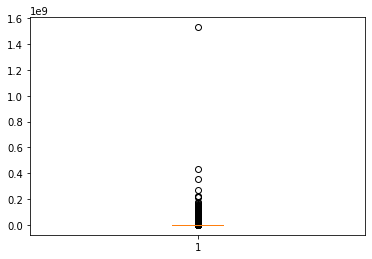

In [ ]:
plt.boxplot(RFM.Monetary)
Q1 = RFM.Monetary.quantile(0.25)
Q3 = RFM.Monetary.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Monetary >= (Q1 - 1.5*IQR)) & (RFM.Monetary <= (Q3 + 1.5*IQR))]

#Outlier treatment for Frequency

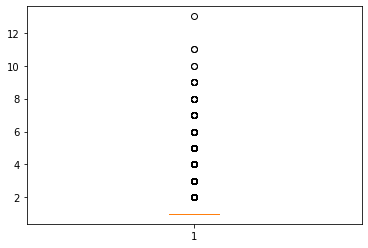

In [ ]:
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

#Outlier treatment for Recency

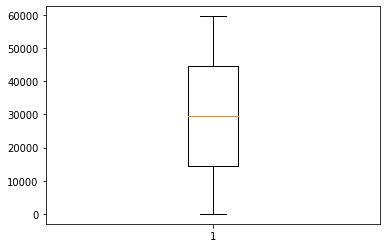

In [ ]:
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [ ]:
RFM.head(20)

,Monetary,Frequency,Recency
ID_Customer,,,
466163,1871560.0,1,30400
466211,432844.0,1,29510
466212,100000.0,1,34350
466270,449541.0,1,29100
466349,266055.0,1,31580
466402,154862.0,1,48000
466410,1256881.0,1,18260
466525,128440.0,1,10170
466584,80000.0,1,3490


#Scaling the RFM data
#Standardise all parameters

In [ ]:
RFM_norm1 =  RFM
RFM_norm1
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1
RFM_norm1.columns = ['Frequency','Monetary','Recency']
RFM_norm1.head()

,Frequency,Monetary,Recency
0,1.805320,0.0,0.038737
1,-0.263494,0.0,-0.012728
2,-0.742110,0.0,0.267147
3,-0.239485,0.0,-0.036436
4,-0.503330,0.0,0.106971


#Hopkins Statistics:

In [ ]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
    return H

In [ ]:
hopkins(RFM_norm1)

0.7940112765356203

#K-Means with some K

###Kmeans with K=3

In [ ]:
model_clus5 = KMeans(n_clusters = 3, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(max_iter=50, n_clusters=3)

##Silhouette Analysis

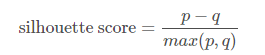

p  is the mean distance to the points in the nearest cluster that the data point is not a part of

q is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

#Silhouette Score For K

In [ ]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)

    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])
    print(sse_ )

[[2, 0.39867035496466846]]
[[2, 0.39867035496466846], [3, 0.4805287241623427]]
[[2, 0.39867035496466846], [3, 0.4805287241623427], [4, 0.3943015460174435]]


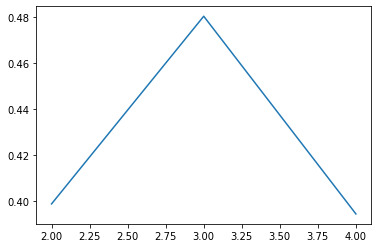

In [ ]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

##Sum of Squared Distances

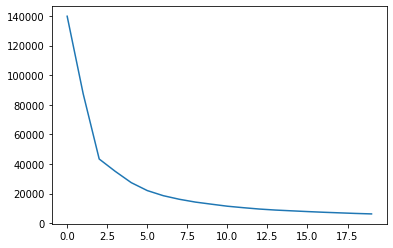

In [ ]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [ ]:
pd.RangeIndex(len(RFM.index))

RangeIndex(start=0, stop=69887, step=1)

In [ ]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = [ 'Recency','Frequency','Monetary' , 'ClusterID']

km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Monetary.mean())


In [ ]:
km_clusters_recency

,Recency
ClusterID,
0,3.624666e+05
1,3.633391e+05
2,1.999738e+06


In [ ]:
km_clusters_amount

,Monetary
ClusterID,
0,45000.640079
1,14551.606968
2,29553.247919


In [ ]:
RFM_km.head()

,Recency,Frequency,Monetary,ClusterID
0,1871560.0,1,30400,2
1,432844.0,1,29510,1
2,100000.0,1,34350,0
3,449541.0,1,29100,1
4,266055.0,1,31580,0


In [ ]:
df = pd.concat([pd.Series([0,1,2]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", 'Monetary' ,'Recency','Frequency']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ClusterID  3 non-null      int64  
 1   Monetary   3 non-null      float64
 2   Recency    3 non-null      int64  
 3   Frequency  3 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 224.0 bytes


#Monetary Cluster For K=3

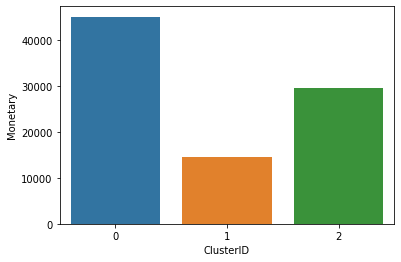

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Monetary)

#Frequency Cluster For K=3






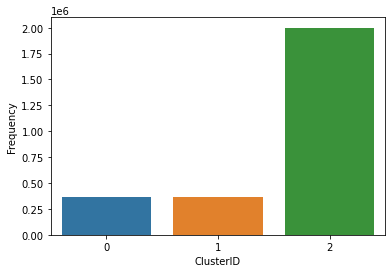

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Frequency)

#Recency Cluster For K=3

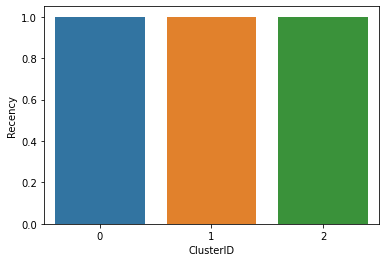

In [ ]:
sns.barplot(x=df.ClusterID, y=df.Recency)

In [ ]:
RFM_km = pd.concat([RFM_km, pd.Series(model_clus5.labels_)], axis=1)
RFM_km

,Recency,Frequency,Monetary,ClusterID,0
0,1871560.0,1,30400,2,2
1,432844.0,1,29510,1,1
2,100000.0,1,34350,0,0
3,449541.0,1,29100,1,1
4,266055.0,1,31580,0,0
...,...,...,...,...,...
69882,120000.0,1,15270,1,1
69883,1249679.0,1,0,1,1
69884,17000.0,1,51200,0,0
69885,105000.0,1,18390,1,1


#Find less Monatery cluster which is the first cluster. This shows amount of money that customers has spent. So, this is the lowest and then we can find the Customer Id who has less amount and then find and recommend cheap item to this group of customers.

In [ ]:
df.Monetary[1]

14551.606967698292

In [ ]:
df_Monetary =  monetary.loc[monetary['Monetary'] < df.Monetary[1]]

df_Monetary

df_Monetary.to_csv('df_Monetary.csv')
df_Cheapest = pd.read_csv("df_Monetary.csv")
df_Cheapest.columns = ["ID_Customer", 'Monetary' ]


In [ ]:
df_Cheapest.ID_Customer

0       467762
1       468409
2       470921
3       471251
4       471713
         ...  
4327    995979
4328    997402
4329    997926
4330    998634
4331    999626
Name: ID_Customer, Length: 4332, dtype: int64

In [ ]:
df = pd.read_csv("orders.csv")
ID_Item=[]
for i in df_Cheapest.ID_Customer:
  df_seek = df.loc[df['ID_Customer'] == i]
  ID_Item.append(df_seek.ID_Item)

ID_Item

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[111693    70303.0
 Name: ID_Item, dtype: float64, 91093    128404.0
 Name: ID_Item, dtype: float64, 105610    735681.0
 Name: ID_Item, dtype: float64, 18653    70153.0
 Name: ID_Item, dtype: float64, 126050    231847.0
 Name: ID_Item, dtype: float64, 70536    215347.0
 Name: ID_Item, dtype: float64, 116397    845171.0
 Name: ID_Item, dtype: float64, 102743    118765.0
 Name: ID_Item, dtype: float64, 8116    70838.0
 Name: ID_Item, dtype: float64, 125604    26471.0
 Name: ID_Item, dtype: float64, 78733    763484.0
 Name: ID_Item, dtype: float64, 61690    48186.0
 Name: ID_Item, dtype: float64, 66164    142597.0
 Name: ID_Item, dtype: float64, 121912    65176.0
 Name: ID_Item, dtype: float64, 15795    501830.0
 Name: ID_Item, dtype: float64, 64799    50155.0
 Name: ID_Item, dtype: float64, 29832    89174.0
 Name: ID_Item, dtype: float64, 129937    48181.0
 Name: ID_Item, dtype: float64, 64705    1671771.0
 Name: ID_Item, dtype: float64, 61324    32458.0
 Name: ID_Item, dtype: float64, 1

#Find high Monatery cluster which is the zero cluster. This shows amount of money that customers has spent. So, this is the largest and then we can find the Customer Id who has the most amount and then find and recommend expensive item to this group of customers.

In [ ]:
df.Monetary[0]

45000.64007861209

In [ ]:
df_Rec =  monetary.loc[monetary['Monetary'] < df.Monetary[0]]

df_Rec
df_Rec.to_csv('df_Rec_Expensive.csv')
df_Expensive = pd.read_csv("df_Rec_Expensive.csv")
df_Expensive.columns = ["ID_Customer", 'Monetary' ]

In [ ]:
df_Expensive.ID_Customer

0       467762
1       468409
2       470921
3       471251
4       471713
         ...  
4327    995979
4328    997402
4329    997926
4330    998634
4331    999626
Name: ID_Customer, Length: 4332, dtype: int64

In [ ]:
df = pd.read_csv("orders.csv")
ID_Item_Expensive=[]
for i in df_Expensive.ID_Customer:
  df_seek_Expensive = df.loc[df['ID_Customer'] == i]
  ID_Item.append(df_seek_Expensive.ID_Item)

ID_Item_Expensive

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[111693    70303.0
 Name: ID_Item, dtype: float64, 91093    128404.0
 Name: ID_Item, dtype: float64, 105610    735681.0
 Name: ID_Item, dtype: float64, 18653    70153.0
 Name: ID_Item, dtype: float64, 126050    231847.0
 Name: ID_Item, dtype: float64, 70536    215347.0
 Name: ID_Item, dtype: float64, 116397    845171.0
 Name: ID_Item, dtype: float64, 102743    118765.0
 Name: ID_Item, dtype: float64, 8116    70838.0
 Name: ID_Item, dtype: float64, 125604    26471.0
 Name: ID_Item, dtype: float64, 78733    763484.0
 Name: ID_Item, dtype: float64, 61690    48186.0
 Name: ID_Item, dtype: float64, 66164    142597.0
 Name: ID_Item, dtype: float64, 121912    65176.0
 Name: ID_Item, dtype: float64, 15795    501830.0
 Name: ID_Item, dtype: float64, 64799    50155.0
 Name: ID_Item, dtype: float64, 29832    89174.0
 Name: ID_Item, dtype: float64, 129937    48181.0
 Name: ID_Item, dtype: float64, 64705    1671771.0
 Name: ID_Item, dtype: float64, 61324    32458.0
 Name: ID_Item, dtype: float64, 1